# Проект II


## Анализ исторической вспышки холеры в Лондоне

#### **Цель:**

В рамках этого проекта мы предлагаем использовать современные методы пространственного анализа для изучения исторической вспышки холеры в Лондоне, в 1854 г.. Цель работы – проанализировать пространственное распределение случаев холеры и выявить закономерности, включая расположение относительно
колодцев с питьевой водой - потенциального источника заражения.

#### **Данные:**

Вам предоставлены два набора данных – местоположения смертельных случаев от холеры и местоположения городских колодцев (водяных насосов) в районе вспышки. Эти данные получены из карты Джона Сноу 1854 года. Их можно скачать [тут](https://github.com/bella-mir/spatialAnalysisCourseFall25/tree/main/projects/data/project2_data)

#### **Требования к итоговому результату:**

- В Jupyter Notebook должны быть последовательно выполнены и отражены все шаги анализа. Код должен быть воспроизводимым, с правильной загрузкой данных и выполнением гео-операций для каждого этапа.
- К каждому ключевому результату должен быть дан **комментарий**: что именно показано на карте или графике
- Итоговая работа должна содержать **выводы**, в которых суммируется выявленная пространственная картина вспышки холеры
- Аккуратное читаемое оформление всегда приветствуется

##### **Формат сдачи задания:**

Файл Jupyter Notebook (`.ipynb`), содержащий весь выполненный анализ и необходимые пояснения. Никакие дополнительные файлы загружать не нужно.

##### **Критерии оценивания (max. 10 баллов):**

- **2 балла** – Корректная загрузка и первичное обследование данных, начальная карта с исходными точками случаев и колодцев.
- **2 балла** – Расчет плотности случаев/смертей по регулярной сетке и наглядная визуализация результата; правильно выделены районы высокой/низкой концентрации и даны им пояснения.
- **2 балла** – Построение диаграммы Вороного и определение числа случаев холеры для каждого колодца; корректное выявление колодца с максимальным числом смертей и обсуждение этого результата.
- **2 балла** – Расчет индекса ближайшего соседа и построение гистограммы расстояний; правильная интерпретация значения NNI и характера распределения расстояний (кластеризация vs. случайность).
- **2 балла** – Качество оформления работы: полнота и ясность выводов, наличие необходимых комментариев к каждому этапу, структурированность ноутбука, а также корректность визуализаций (оформление карт и графиков).


##### **Шаги работы**

### Шаг 1.1. Чтение данных

Загрузите данные о случаях холеры и о колодцах в GeoPandas. Убедитесь, что данные считаны корректно (например, посмотрите первые несколько строк). Задайте соответствующую систему координат (широта/долгота, EPSG:4326) при чтении, если необходимо.


In [1]:
import geopandas as gpd

# Пути к данным
cholera_deaths_path = r".\data\project2_data\Cholera_deaths_ll.shp"
wells_path = r".\data\project2_data\Pumps_ll.shp"

# Загрузка данных о случаях холеры
cholera_gdf = gpd.read_file(cholera_deaths_path)
cholera_gdf = cholera_gdf.to_crs(epsg=4326)  # Установка CRS широта/долгота (WGS84)
print("Первые 5 строк данных о случаях холеры:")
display(cholera_gdf.head())

# Загрузка данных о колодцах
wells_gdf = gpd.read_file(wells_path)
wells_gdf = wells_gdf.to_crs(epsg=4326)
print("Первые 5 строк данных о колодцах:")
display(wells_gdf.head())


Первые 5 строк данных о случаях холеры:


,OBJECTID,Id,Count,Streetname,Xcoord,Ycoord,geometry
0,1,1,3,Marshall St,-0.137813,51.513414,POINT (-0.13781 51.51341)
1,2,2,2,Marshall St,-0.137806,51.513358,POINT (-0.13781 51.51336)
2,3,3,1,Marshall St,-0.137759,51.513292,POINT (-0.13776 51.51329)
3,4,4,1,Marshall St,-0.137728,51.513242,POINT (-0.13773 51.51324)
4,5,5,4,Marshall St,-0.137661,51.513190,POINT (-0.13766 51.51319)


Первые 5 строк данных о колодцах:


,OBJECTID,Id,pumpname,Xcoord,Ycoord,geometry
0,1,1,Broad St,-0.136589,51.513302,POINT (-0.13659 51.5133)
1,2,2,Carnaby St,-0.139529,51.513828,POINT (-0.13953 51.51383)
2,3,3,Marlborough Mews,-0.139642,51.514868,POINT (-0.13964 51.51487)
3,4,4,King St,-0.131546,51.512302,POINT (-0.13155 51.5123)
4,5,5,Upper Rupert St,-0.133518,51.512073,POINT (-0.13352 51.51207)


### Шаг 1.2. Изучение данных

Проанализируйте структуру данных:

- Сколько записей (случаев заболевания/смертей) содержится в наборе?
- Какие атрибуты присутствуют (например, может быть адрес или количество случаев по адресу)?
- Сколько колодцев отмечено на карте, и где они расположены относительно очагов заболевания?


In [2]:

# Количество записей
num_cholera_cases = len(cholera_gdf)
print(f"Число записей: {num_cholera_cases}")

# Просмотр атрибутов (столбцов)
print("Атрибуты данных о случаях холеры:")
print(cholera_gdf.columns.tolist())

# Суммарное количество смертей
total_deaths = cholera_gdf['Count'].sum()
print(f"Суммарное количество смертей: {total_deaths}")

# Сколько колодцев
num_wells = len(wells_gdf)
print(f"Число колодцев: {num_wells}")

Число записей: 313
Атрибуты данных о случаях холеры:
['OBJECTID', 'Id', 'Count', 'Streetname', 'Xcoord', 'Ycoord', 'geometry']
Суммарное количество смертей: 569
Число колодцев: 13


В данных есть координаты, названия улиц и количество смертей по данному адресу

In [3]:
import folium
from folium.plugins import MarkerCluster

center = [cholera_gdf.geometry.y.mean(), cholera_gdf.geometry.x.mean()]
m = folium.Map(location=center, zoom_start=16, tiles="CartoDB positron")

cholera = MarkerCluster(name="Заражения").add_to(m)
for _, row in cholera_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.7,
        popup=row.get("Count", "") # при нажатии на точку отображаем количество смертей
    ).add_to(cholera)

wells = MarkerCluster(name="Колодцы").add_to(m)
for _, row in wells_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=9,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.7,
        popup=row.get("pumpname", "") # при нажатии на точку отображаем название колодца
    ).add_to(wells)

# Добавим возможность включать/выключать слои
folium.LayerControl().add_to(m)

# Покажем карту
m


1. Все заболевания расположены между колодцами, колодцы здесь выступают границей зараженной зоны
2. Наибольшие очаги сосредоточены в районе Soho, вокруг колодца `Broad St`

### Шаг 2.1. Плотность случаев холеры

Оцените пространственное распределение холеры по плотности, аналогично тому, как мы считали плотность кафе:

- Постройте регулярную сетку, покрывающую район исследования.
- Выполните spatial join, чтобы определить количество случаев (точек) холеры в каждой ячейке.
- Вычислите **плотность случаев холеры** (количество случаев на км²) для каждой ячейки.
- Постройте карту плотности случаев. Где концентрация случаев наиболее высокая?


In [ ]:
from shapely.geometry import box


def create_regular_grid(gdf, square_size):
    # Если набор в географических координатах, перепроецируем в UTM
    utm_crs = gdf.estimate_utm_crs()
    gdf_utm = gdf.to_crs(utm_crs)
    # Получаем границы (bounding box) области
    minX, minY, maxX, maxY = gdf_utm.total_bounds
    grid_cells = []
    x, y = minX, minY
    # Двойной цикл: заполняем прямоугольник границ квадратами заданного размера
    while y <= maxY:
        while x <= maxX:
            grid_cells.append(box(x, y, x + square_size, y + square_size))
            x += square_size # двигаемся по X
        x = minX             # возврат к началу по X
        y += square_size     # двигаемся по Y (следующий ряд)
    # Формируем GeoDataFrame
    fishnet = gpd.GeoDataFrame(geometry=grid_cells, crs=utm_crs)
    return fishnet


In [5]:
# Создаем регулярную сетку с размером ячейки 100 метров
fishnet = create_regular_grid(cholera_gdf, square_size=100)
print(f"Создано ячеек: {len(fishnet)}")

# Перепроецируем данные о холере в UTM для работы с сеткой
utm_crs = cholera_gdf.estimate_utm_crs()
cholera_gdf_utm = cholera_gdf.to_crs(utm_crs)

# Выполняем пространственное объединение: определяем, в какой ячейке находится каждый случай холеры
cholera_in_grid = gpd.sjoin(cholera_gdf_utm, fishnet, predicate="within", how="left")

# Подсчитываем количество случаев в каждой ячейке
cholera_count_per_cell = cholera_in_grid.groupby('index_right').size()

# Добавляем столбец с количеством случаев в соответствующую ячейку сетки
fishnet['cholera_count'] = cholera_count_per_cell
fishnet['cholera_count'] = fishnet['cholera_count'].fillna(0).astype(int)

print("\nСтатистика по ячейкам:")
print(f"Максимальное количество случаев в ячейке: {fishnet['cholera_count'].max()}")
print(f"Среднее количество случаев в ячейке: {fishnet['cholera_count'].mean():.0f}")

# Вычисляем площадь каждой ячейки в квадратных метрах и плотность случаев
cell_area_m2 = fishnet.geometry.area
# Добавляем столбец плотности холеры (число случаев на 1 км²)
fishnet['cholera_density'] = fishnet['cholera_count'] / (cell_area_m2 / 1e6)

print(f"\nМаксимальная плотность: {fishnet['cholera_density'].max():.0f} случаев на км²")

# Визуализируем плотность случаев холеры
fishnet.explore(
    column='cholera_density', 
    cmap='Reds', 
    scheme='NaturalBreaks', 
    legend=True,
    legend_kwds={'caption': 'Случаи холеры на км²'}, 
    tiles='CartoDB positron'
)

Создано ячеек: 36

Статистика по ячейкам:
Максимальное количество случаев в ячейке: 44
Среднее количество случаев в ячейке: 9

Максимальная плотность: 4400 случаев на км²


Наиболее высокая концентрация случаев расположена в районе Broad Street, что указывает на эпицентр вспышки


### Шаг 2.2. Плотность смертельных случаев

Если в данных случаи уже агрегированы (например, указано количество смертей по адресу), повторите анализ, учитывая вес точек:

- Рассчитайте плотность **смертей** (например, суммарное число смертей на км² в пределах каждой ячейки).
- Сравните с картой плотности точек из шага 2.1. Отличаются ли результаты? (Если данные уже представлены как одна смерть = одна точка, этот шаг аналогичен 2.1.)


In [6]:
# Создаем регулярную сетку с размером ячейки 100 метров
fishnet = create_regular_grid(cholera_gdf, square_size=100)
print(f"Создано ячеек: {len(fishnet)}")

# Перепроецируем данные о холере в UTM для работы с сеткой
utm_crs = cholera_gdf.estimate_utm_crs()
cholera_gdf_utm = cholera_gdf.to_crs(utm_crs)

# Выполняем пространственное объединение: определяем, в какой ячейке находится каждый случай смерти от холеры
cholera_in_grid = gpd.sjoin(cholera_gdf_utm, fishnet, predicate="within", how="left")

# Подсчитываем количество смертей в каждой ячейке
cholera_count_per_cell = cholera_in_grid.groupby('index_right').sum("Count")["Count"]

# Добавляем столбец с количеством смертей в соответствующую ячейку сетки
fishnet['death_count'] = cholera_count_per_cell
fishnet['death_count'] = fishnet['death_count'].fillna(0).astype(int)

print("\nСтатистика по ячейкам:")
print(f"Максимальное количество смертей в ячейке: {fishnet['death_count'].max()}")
print(f"Среднее количество смертей в ячейке: {fishnet['death_count'].mean():.0f}")

# Вычисляем площадь каждой ячейки в квадратных метрах и плотность смертей
cell_area_m2 = fishnet.geometry.area
# Добавляем столбец плотности холеры (число смертей на 1 км²)
fishnet['death_density'] = fishnet['death_count'] / (cell_area_m2 / 1e6)

print(f"\nМаксимальная плотность: {fishnet['death_density'].max():.0f} смертей на км²")

# Визуализируем плотность смертей холеры
fishnet.explore(
    column='death_density', 
    cmap='Reds', 
    scheme='NaturalBreaks', 
    legend=True,
    legend_kwds={'caption': 'Случаи холеры на км²'}, 
    tiles='CartoDB positron'
)

Создано ячеек: 36

Статистика по ячейкам:
Максимальное количество смертей в ячейке: 88
Среднее количество смертей в ячейке: 16

Максимальная плотность: 8800 смертей на км²


Карта совпадает с предыдущим пунктом, различаются лишь абсолютные значения - они выше примерно в 2 раза

### Шаг 2.3. Сравнение результатов

Опишите, что показывают карты плотности:

- Совпадают ли районы с наибольшим числом точек случаев и наибольшим числом смертей?
- Какие области можно назвать эпицентром вспышки по этим картам?


- Да, районы полностью совпадают
- Broadwick Street, пересечения Broadwick Street с Marshall, Lexington, Poland, Ingestre и Berwick Street

### Шаг 3. Диаграмма Вороного (зоны ближайшего колодца)

Постройте диаграмму Вороного для колодцев:

- Обрежьте получившиеся полигоны границами района вспышки (чтобы зоны влияния ограничивались областью анализа). Можно для простоты использовать bounding box данных или границу района из карты.
- Постройте карту, где показаны полигоны Вороного вокруг каждого колодца.


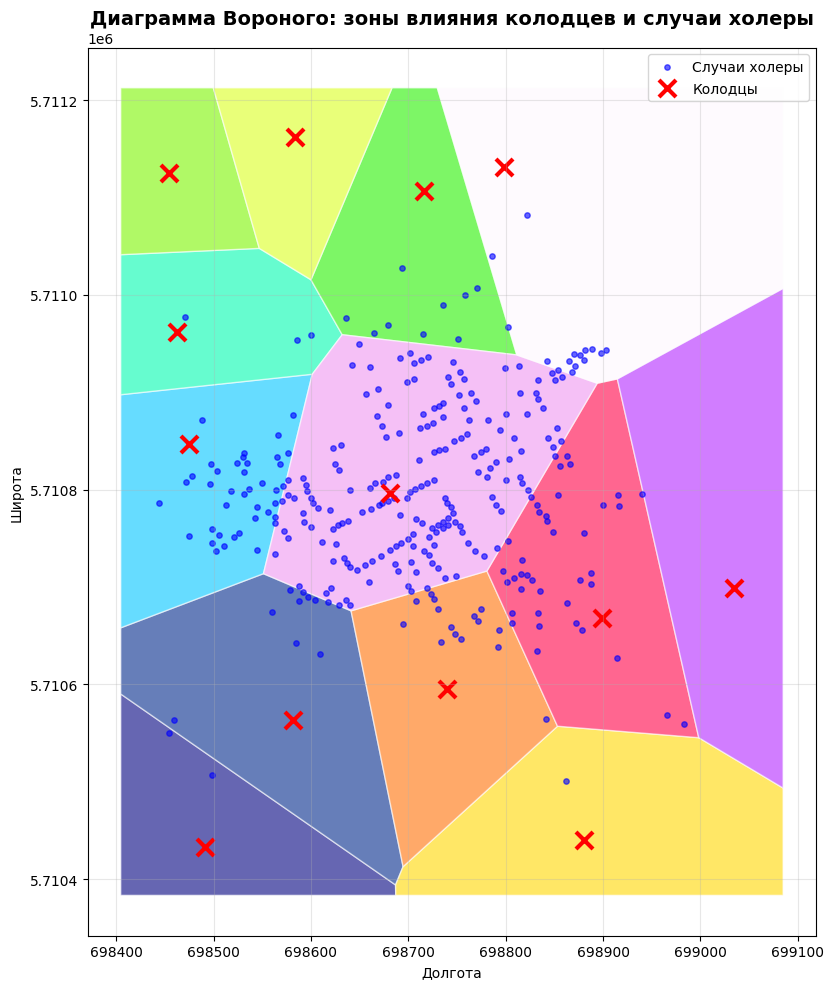

In [ ]:
from shapely.ops import voronoi_diagram
from shapely.geometry import MultiPoint, box
import matplotlib.pyplot as plt

# 1. Перепроецируем данные колодцев и холеры в UTM для корректной работы
utm_crs = cholera_gdf.estimate_utm_crs()
wells_gdf_utm = wells_gdf.to_crs(utm_crs)
cholera_gdf_utm = cholera_gdf.to_crs(utm_crs)

# 2. Создаем bounding box (рамку) для ограничения диаграммы Вороного
# Используем границы данных о холере для создания прямоугольной области
minx, miny, maxx, maxy = wells_gdf_utm.total_bounds
padding = 50  # добавим 50 метров с каждой стороны
envelope = box(minx - padding, miny - padding, maxx + padding, maxy + padding)

# 3. Собираем точки-колодцы в MultiPoint
points_mp = MultiPoint(wells_gdf_utm.geometry.tolist())

# 4. Генерируем диаграмму Вороного, ограничивая её рамкой исследования
vor = voronoi_diagram(points_mp, envelope=envelope)

# 5. Создаём GeoDataFrame из полигонов Вороного
cells = list(vor.geoms)
vor_gdf = gpd.GeoDataFrame(geometry=cells, crs=utm_crs)
clipped_vor = gpd.clip(vor_gdf, envelope)

# 6. Визуализация результата
fig, ax = plt.subplots(figsize=(12, 10))

# Рисуем полигоны диаграммы Вороного
clipped_vor.plot(
    ax=ax,
    cmap='gist_ncar',
    edgecolor='white',
    alpha=0.6,
)

# Наносим случаи холеры поверх полигонов
cholera_gdf_utm.plot(
    ax=ax,
    color='blue',
    markersize=15,
    alpha=0.6,
    label='Случаи холеры'
)

# Наносим колодцы поверх полигонов
wells_gdf_utm.plot(
    ax=ax,
    color='red',
    markersize=150,
    marker='x',
    linewidth=3,
    label='Колодцы'
)

# Настройка оформления
ax.set_title(
    "Диаграмма Вороного: зоны влияния колодцев и случаи холеры",
    fontsize=14,
    fontweight='bold'
)
ax.set_xlabel('Долгота', fontsize=10)
ax.set_ylabel('Широта', fontsize=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Здесь также наблюдаем наибольшее скопление точек в зоне влияния колодца на Broad St

### Шаг 4. Случаи холеры в зоне каждого колодца

Используя полученные полигоны Вороного, определите, сколько случаев (и отдельно – смертей) холеры пришлось на область каждого колодца:

- Выполните spatial join между точками случаев и полигонами Вороного, чтобы присвоить каждому случаю ближайший колодец.
- Просуммируйте количество случаев для каждого полигона (колодца).
- Определите, возле какого колодца произошло максимальное число случаев.


In [13]:
# 1. Выполняем spatial join между точками случаев холеры и полигонами Вороного
# Это присвоит каждому случаю ближайший колодец
cholera_with_wells = gpd.sjoin(cholera_gdf_utm, clipped_vor, predicate="within", how="left")

# 2. Подсчитываем количество случаев для каждого полигона Вороного (колодца)
cases_per_well = cholera_with_wells.groupby('index_right').size()

# 3. Добавляем информацию о количестве случаев в GeoDataFrame полигонов Вороного
clipped_vor['cholera_cases'] = cases_per_well
clipped_vor['cholera_cases'] = clipped_vor['cholera_cases'].fillna(0).astype(int)

# 4. Подсчитываем количество смертей для каждого полигона (колодца)
# Если Count отсутствует, считаем как 1 смерть
cholera_with_wells['Count'] = cholera_with_wells['Count'].fillna(1)
deaths_per_well = cholera_with_wells.groupby('index_right')['Count'].sum()

# 5. Добавляем информацию о количестве смертей в GeoDataFrame
clipped_vor['cholera_deaths'] = deaths_per_well
clipped_vor['cholera_deaths'] = clipped_vor['cholera_deaths'].fillna(0).astype(int)

# 6. Создадим таблицу для удобного просмотра статистики по колодцам
# Сначала добавим информацию о колодцах к полигонам
wells_with_vor = gpd.sjoin(wells_gdf_utm, clipped_vor, predicate="within", how="inner")
# Создаем словарь для присвоения имен колодцев полигонам
wells_dict = wells_with_vor.set_index('index_right')['pumpname'].to_dict()
clipped_vor['well_name'] = clipped_vor.index.map(wells_dict)

# Выводим топ-5 колодцев по количеству смертей
top_wells = clipped_vor.nlargest(5, 'cholera_deaths')[['well_name', 'cholera_cases', 'cholera_deaths']]
print("\nТоп-5 колодцев по количеству смертей:")
display(top_wells.reset_index(drop=True))


Топ-5 колодцев по количеству смертей:


,well_name,cholera_cases,cholera_deaths
0,Broad St,181,352
1,Carnaby St,39,68
2,Upper Rupert St,39,62
3,Bridle St,15,26
4,Newman St,13,23


Видим, что больше всего случаев заражения по прежнему около колодца на Broad St

### Шаг 5. Nearest Neighbour Index для случаев холеры

Рассчитайте **индекс ближайшего соседа** для случаев холеры (используя координаты всех индивидуальных случаев или всех смертей):

- Выполните шаги, аналогичные примеру с пабами: найдите среднее расстояние от случая холеры до ближайшего соседнего случая.
- Сравните с ожидаемым средним расстоянием при случайном распределении (формула с площадью области и количеством случаев).
- Полученное значение NNI – меньше 1, около 1 или больше 1? Что это говорит о характере распределения случаев холеры (кластеризованы ли они)?


Среднее расстояние до ближайшего соседа: 11.9 метров


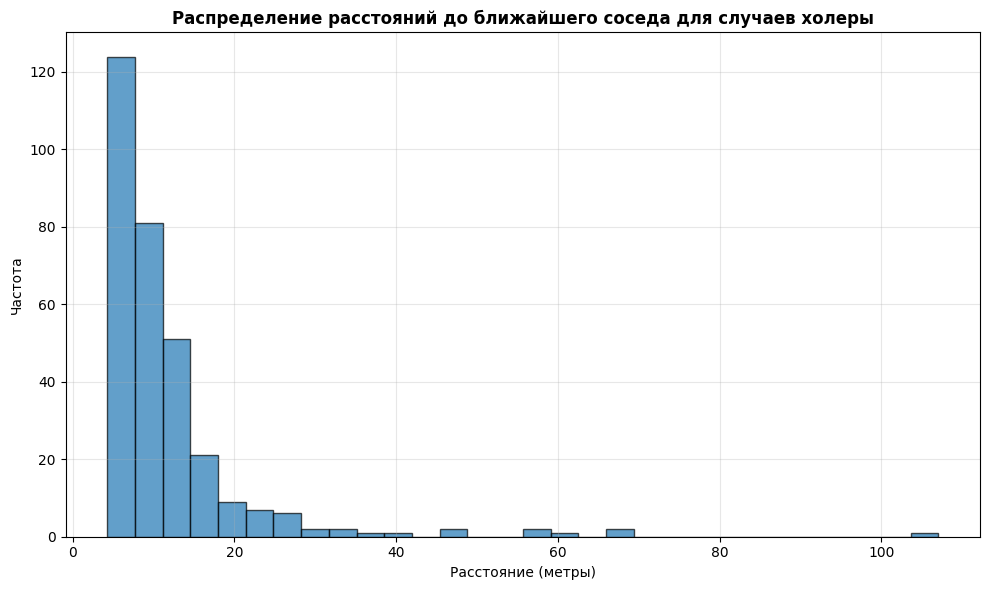

Площадь области исследования: 251049 м²
Ожидаемое среднее расстояние (случайное распределение): 14.2 метров

Nearest Neighbor Index (NNI): 0.842


In [ ]:
import numpy as np

# 1. Расчет расстояний до ближайшего соседа для случаев холеры
distances = []
for point in cholera_gdf_utm.geometry:
    dist = cholera_gdf_utm.geometry.distance(point)
    dist = dist[dist > 0]  # исключаем нулевые значения
    distances.append(np.min(dist))

# Вычисление среднего расстояния до ближайшего соседа
average_nearest_neighbor_distance = np.mean(distances)
print(f"Среднее расстояние до ближайшего соседа: {average_nearest_neighbor_distance:.1f} метров")

# 2. Визуализация гистограммы распределения расстояний
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=30, edgecolor='black', alpha=0.7)
plt.title("Распределение расстояний до ближайшего соседа для случаев холеры", fontsize=12, fontweight='bold')
plt.xlabel("Расстояние (метры)", fontsize=10)
plt.ylabel("Частота", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Вычисление площади области исследования (используем выпуклую оболочку)
convex_hull = cholera_gdf_utm.geometry.union_all().convex_hull
convex_hull_gdf = gpd.GeoDataFrame({'geometry': [convex_hull]}, crs=utm_crs)
study_area = convex_hull_gdf.area.values[0]  # площадь в м²
print(f"Площадь области исследования: {study_area:.0f} м²")

# 4. Расчет ожидаемого среднего расстояния для случайного распределения точек
n = len(distances)
expected_mean_distance = 0.5 * np.sqrt(study_area / n)
print(f"Ожидаемое среднее расстояние (случайное распределение): {expected_mean_distance:.1f} метров")

# 5. Расчет Nearest Neighbor Index (NNI)
NNI = average_nearest_neighbor_distance / expected_mean_distance
print(f"\nNearest Neighbor Index (NNI): {NNI:.3f}")

NHI < 1, поэтому случаи холеры кластеризованы

### Шаг 6. Выводы

Подведите итог проделанного анализа. На основе всех полученных результатов:

- **Где** находился эпицентр эпидемии холеры?
- Связан ли он с каким-либо конкретным колодцем (если да, укажите с каким)?
- Что говорит индекс ближайшего соседа о пространственном характере вспышки?
- Какой метод анализа показался наиболее наглядным для данного кейса и почему?


- Эпицентр находился в районе сохо, вокруг колодца на **Брод-стрит**
- Индекс ближайшего соседа говорит о том, что распределение случаев заражения скорее **кластеризовано**, чем случайно
- Наиболее наглядным мне показался метод, использующий **диаграмму Вороного**. Здесь мы получили конкретную область эпицентра болезни без заранее заданных параметров

---

**Примечание:** Исторически Джон Сноу обнаружил, что большинство случаев сконцентрировались вокруг одного водяного насоса на Брод-стрит, что позволило ему предположить водный путь распространения болезни. Ваш анализ должен подтвердить или уточнить эту классическую гипотезу с помощью современных инструментов геоаналитики. Удачи!
